<a href="https://colab.research.google.com/github/auphong2707/emotion-dectection-from-text/blob/preprocess-hotfix---Kleecon/EDFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The project aims to create a **Machine Learning** powered model which is capable of classifying the emotions of the text (in the form of short quotes/comments) with predefined labels of emotions.

Emotion detection, also known as sentiment analysis, is now one of the most attractive subfields of Machine Learning, especially Natural Language Processing (NLP) due to its wide applications in many aspects of modern life, such as providing emotional information to help people developing insights or making decisions. In this project, we specifically try to convey the main emotion of a comment sentence. Generally, we expect the model to be able to take the input sentence in the form of short comments and returns its major emotion(s), corresponding to one of the predefined labels.

Our approach to solving this problem is to split it into two halves:

  1.   Data Preprocessing
  2.   Model training and Result

For detail of each half, please go into the section


The dataset we use in this project is obtained from Kaggle: [EDFT Dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

Connect to Google Drive

# **Data Preprocessing**

## Importation & Data loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preparing necessary packages (may need to add more):

In [2]:
import numpy as np  # Work with multi-dimenional data
import pandas as pd # Work with relational data
import matplotlib.pyplot as plt # Visualize data
import seaborn as sns # Visualize data base on matplotlib

import warnings
warnings.filterwarnings("ignore")
# Because I hate seeing stupid warnings~

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
# Used for automatic feature extraction
from sklearn.pipeline import Pipeline
# Used for automating processes

Load data from files

In [4]:
%cd /content/drive/MyDrive/EDFT_data/

# Get all data
files = ['train.txt', 'val.txt']

X_raw = list()
Y_raw = list()
for file in files:
  f = open(file, 'r')
  for line in f:
    line = line.strip('\n')
    x_raw, y_raw = line.split(sep=';')

    X_raw.append(x_raw)
    Y_raw.append(y_raw)
  f.close()

/content/drive/MyDrive/EDFT_data


## Feature Extraction


Removing the stopword (stop word list given at https://countwordsfree.com/stopwords)


In [6]:
file = open("stop_words_english.txt", 'r')
stopword_list = file.read().split('\n')
file.close()

# Due to the fact that the word "feel" takes too much space...
stopword_list.append("feel")
stopword_list.append("feeling")
stopword_list.append("time")
stopword_list.append("bit")
stopword_list.append("ive")
stopword_list.append("im")

In [7]:
# These codes do the same things

# Handcode (edited to return bigrams as well)
dictionary = set()
c = 0
for quoted in X_raw:
  c += 1
  if c == 2:
    print(quoted)
  quote = ' ' + quoted + ' '
  for stopword in stopword_list:
    quote = ' '.join(quote.split((' '+stopword+' ')))
  quote = quote.split()
  for i in range(len(quote)):
    dictionary.add(quote[i])
    if i != 0:
      dictionary.add(' '.join([quote[i], quote[i-1]]))
  break

# Scikit (using CountVectorizer)
count_vector = CountVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
bow = count_vector.fit_transform(X_raw)
dictionary2 = count_vector.get_feature_names_out()
for i in bow[1].nonzero()[1]:
  print(count_vector.get_feature_names_out()[i])
# bow already outputs the BoW array.
# If you want to output the TF-IDF array, use TfidfVectorizer instead.

# count_vector.vocabulary_.keys()

tfidf_vector = TfidfVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
tfidf = tfidf_vector.fit_transform(X_raw)



i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
hopeless
damned
hopeful
cares
awake
hopeless damned
damned hopeful
hopeful cares
cares awake


*Luckily we're quite done with the abbreviations!*

Another way: Using Word2Vec to capture the semantics
(Um, we'd talk about that later, ok?)


## Exploratory Data Analysis (EDA)

Average length of the comment:

In [9]:
# Calculate average number of characters
sum_of_chars = sum([len(x) for x in X_raw])
mean_number_chars = sum_of_chars / len(X_raw)

# Calculate average number of words
sum_of_words = sum([len(x.split()) for x in X_raw])
mean_number_words = sum_of_words / len(X_raw)

# Print
print('The mean number of characters of each line is: %d' % mean_number_chars)
print('The mean number of words of each line is: %d' % mean_number_words)

The mean number of characters of each line is: 96
The mean number of words of each line is: 19


Statistic of output labels:

Number of labels is: 6
Labels: joy, surprise, sadness, fear, love, anger

----------------------------------------------------------------------------



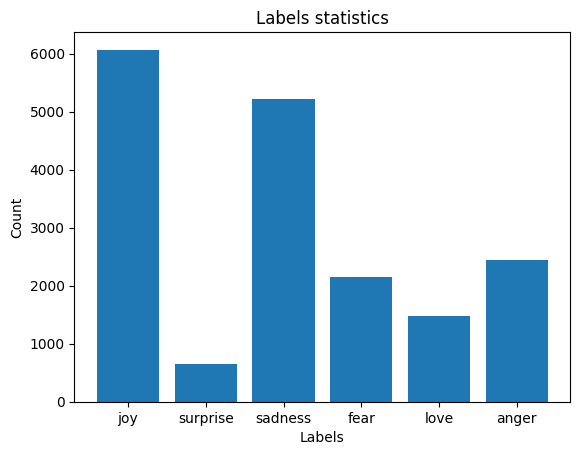

In [10]:
# Number of labels:
labels = list(set(Y_raw))
print('Number of labels is: %d' % len(labels))
print('Labels: ' + ', '.join(labels))
print('\n----------------------------------------------------------------------------\n')

# Plot:
label_elements_count = np.asarray([Y_raw.count(label) for label in labels])
labels = np.asarray(labels)

plt.title(label='Labels statistics')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.bar(x=labels, height=label_elements_count)

plt.show()

Statistics of words with the highest frequency of each label:

In [11]:
vect_arr = bow.toarray()
vect_aggr = np.zeros(shape=(len(labels), vect_arr.shape[1]))

for idx in range(len(vect_arr)):
  label_idx = int(np.where(labels==Y_raw[idx])[0][0])

  vect_aggr[label_idx] += vect_arr[idx]

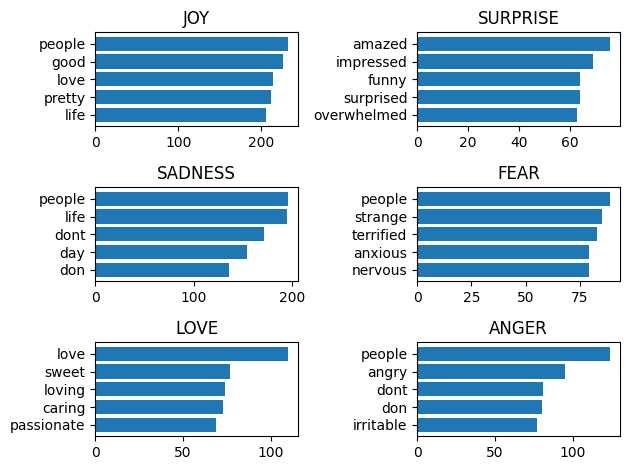

In [12]:
fig, axs = plt.subplots(3, 2)

for label_idx in range(len(labels)):
  axs_x, axs_y = label_idx // 2, label_idx % 2

  plt_ref = axs[axs_x][axs_y]
  plt_ref.set_title(labels[label_idx].upper())

  x_axis, y_axis = list(), list()
  n_argmax = np.argpartition(vect_aggr[label_idx], -5)[-5:]
  n_argmax = n_argmax[np.argsort(vect_aggr[label_idx][n_argmax])]
  for i in n_argmax:
    x_axis.append(dictionary2[i])
    y_axis.append(vect_aggr[label_idx][i])

  x_axis = np.asarray(x_axis)
  y_axis = np.asarray(y_axis)

  plt_ref.barh(x_axis, y_axis)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Model training and result**

##General

We train some models from simple to complex:


*   K-nearest neighbors (KNN)
*   Naive Bayes Classification
*   K-means clusters
*   Neural network









## K-nearest neighbors (KNN)

## Naive Bayes classification

# **Conclusion**